Numerical Solution of 2D heat equation

Text(0.5, 1.0, 'Numerical Solution')

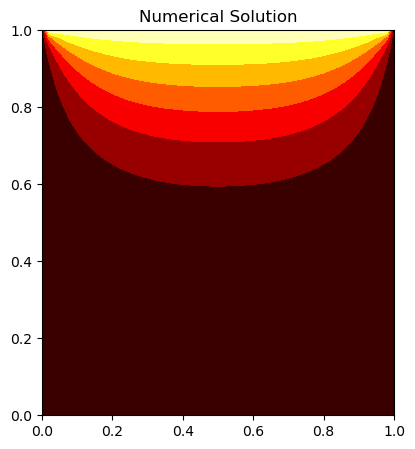

In [90]:
import numpy as np
import matplotlib.pyplot as plt

# parameters
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 1.0
nx, ny = 50, 50  # Number of grid points in x and y directions
dx = (xmax - xmin) / (nx - 1)
dy = (ymax - ymin) / (ny - 1)
alpha = 0.01  # Diffusivity coefficient


#  grid
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

# temperature array
T = np.zeros((nx, ny))

# Dirichlet boundary conditions
T[0, :] = 0  # Bottom boundary
T[-1, :] = 1  # Top boundary
T[:, 0] = 0  # Left boundary
T[:, -1] = 0  # Right boundary

#  iterative solution using finite differences
for _ in range(10000):
    T_new = np.copy(T)
    for i in range(1, nx - 1):
        for j in range(1, ny - 1):
            T_new[i, j] = (alpha * (T[i + 1, j] + T[i - 1, j] + T[i, j + 1] + T[i, j - 1]) +
                           (1 - 4 * alpha) * T[i, j])
    T = np.copy(T_new)


# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.contourf(X, Y, T, cmap='hot')
plt.title('Numerical Solution')



Analytical equation

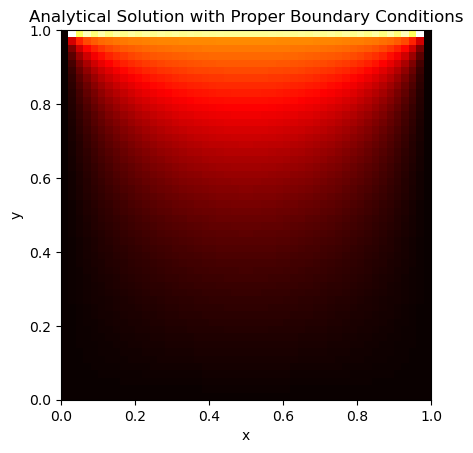

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 1.0
nx, ny = 50, 50  # Number of grid points in x and y directions

# Grid
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)
# Apply boundary conditions
T = np.zeros((ny, nx))
def analytical_solution(n_terms=50):
    L = xmax - xmin
    H = ymax - ymin

    for i in range(nx):
        for j in range(ny):
            x_val = X[j, i]
            y_val = Y[j, i]
            for n in range(1, n_terms + 1):
                Bn = (4 / (n * np.pi)) * ((1 - (-1) ** n) / np.sinh(n * np.pi))
                T[j, i] += Bn * np.sin(n * np.pi * x_val / L) * np.sinh(n * np.pi * y_val / H)

    return T

# Compute
T_analyticalwb = analytical_solution_with_boundary()

# Plot
plt.imshow(T_analytical, cmap='hot', extent=[xmin, xmax, ymin, ymax], origin='lower')
plt.title('Analytical Solution with Proper Boundary Conditions')
plt.xlabel('x')
plt.ylabel('y')
plt.show()



Error in the Numerical solution with respect to Analytical

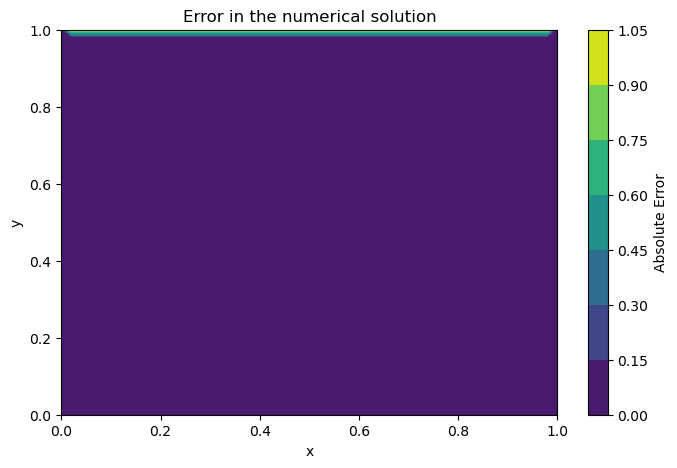

In [99]:
error = np.abs(T_analytical - T)
plt.figure(figsize=(8, 5))
plt.contourf(X, Y, error, cmap='viridis')
plt.title('Error in the numerical solution')
plt.colorbar(label='Absolute Error')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

consider following reference PINN code

code has been modified to collect the epoch and loss values

Activation function: Tanh

Epoch 0, Loss: 0.29544914
Epoch 100, Loss: 0.09494875
Epoch 200, Loss: 0.08042546
Epoch 300, Loss: 0.04776572
Epoch 400, Loss: 0.03323237
Epoch 500, Loss: 0.02997697
Epoch 600, Loss: 0.02770243
Epoch 700, Loss: 0.02638034
Epoch 800, Loss: 0.02558287
Epoch 900, Loss: 0.02627904
Epoch 1000, Loss: 0.02499647
Epoch 1100, Loss: 0.02444203
Epoch 1200, Loss: 0.02464817
Epoch 1300, Loss: 0.02371287
Epoch 1400, Loss: 0.02352923
Epoch 1500, Loss: 0.02339686
Epoch 1600, Loss: 0.02318058
Epoch 1700, Loss: 0.02303268
Epoch 1800, Loss: 0.02695911
Epoch 1900, Loss: 0.02274537
Epoch 2000, Loss: 0.02258976
Epoch 2100, Loss: 0.02249350
Epoch 2200, Loss: 0.02234796
Epoch 2300, Loss: 0.02343137
Epoch 2400, Loss: 0.02210909
Epoch 2500, Loss: 0.02197050
Epoch 2600, Loss: 0.02196574
Epoch 2700, Loss: 0.02175697
Epoch 2800, Loss: 0.02162932
Epoch 2900, Loss: 0.02156589
Epoch 3000, Loss: 0.02145013


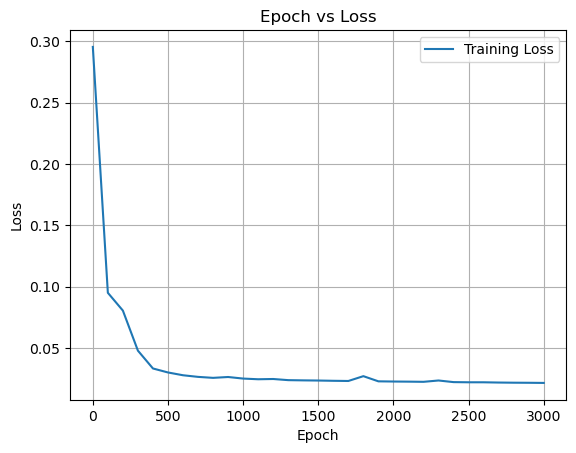

In [103]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1) 
        )

    def forward(self, x, y):
        T = self.net(torch.cat([x,y], dim=1))
        return T
    
model = PINN()

def pde(x,y):
    x.requires_grad=True
    y.requires_grad=True
    T = model(x,y)
    T_x = torch.autograd.grad(T, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_y = torch.autograd.grad(T, y, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_xx = torch.autograd.grad(T_x, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_yy = torch.autograd.grad(T_y, y, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    residual = torch.mean((T_xx + T_yy)**2)
    return residual

#Domain Size
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 1.0

# Residual Points
x_r, y_r = torch.rand(5000)*(xmax-xmin) + xmin, torch.rand(5000)*(ymax-ymin) + ymin
x_r = x_r.view(-1,1)
y_r = y_r.view(-1,1)

# Boundary points
y_left_right = torch.linspace(ymin, ymax, 200).view(-1,1)

x_left_bc = xmin*torch.ones_like(y_left_right).view(-1,1)
x_right_bc = xmax*torch.ones_like(y_left_right).view(-1,1)

x_top_bottom = torch.linspace(xmin+0.01, xmax-0.01, 200).view(-1,1)

y_top_bc = ymax*torch.ones_like(x_top_bottom).view(-1,1)
y_bottom_bc = ymin*torch.ones_like(x_top_bottom).view(-1,1)

T_left = torch.zeros_like(x_left_bc).view(-1,1)
T_right = torch.zeros_like(x_right_bc).view(-1,1)

T_bottom = torch.zeros_like(y_bottom_bc).view(-1,1)
T_top = torch.ones_like(y_bottom_bc).view(-1,1)

y_bc = torch.cat([y_left_right,y_left_right, y_top_bc, y_bottom_bc], dim=0)
x_bc = torch.cat([x_left_bc,x_right_bc, x_top_bottom, x_top_bottom], dim=0)
T_bc = torch.cat([T_left, T_right, T_top, T_bottom], dim=0)

def bc_condition(x,y,T):
    T_pred = model(x,y)
    return torch.mean((T - T_pred)**2) # return boundary loss

# Loss function combining PDE, initial condition and boundary condition
def loss_func(x_bc, y_bc, T_bc, x_r, y_r):

    boundary_loss = bc_condition(x_bc,y_bc,T_bc)
    
    pde_loss = pde(x_r, y_r)

    return pde_loss + boundary_loss

# Training setup
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 3001

# Lists to store epoch and loss values
epoch_list = []
loss_list = []

# Training loop
for epoch in range(num_epochs):
    loss = loss_func(x_bc, y_bc, T_bc, x_r, y_r)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.8f}")
        # Appending epoch and loss 
        epoch_list.append(epoch)
        loss_list.append(loss.item())

# epoch vs loss graph
plt.plot(epoch_list, loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.grid(True)
plt.show()



Activation function: ReLU

Epoch 0, Loss: 0.35965261
Epoch 100, Loss: 0.03692240
Epoch 200, Loss: 0.01066652
Epoch 300, Loss: 0.00600142
Epoch 400, Loss: 0.00400498
Epoch 500, Loss: 0.00291853
Epoch 600, Loss: 0.00215347
Epoch 700, Loss: 0.00176137
Epoch 800, Loss: 0.00137975
Epoch 900, Loss: 0.00109363
Epoch 1000, Loss: 0.00089475
Epoch 1100, Loss: 0.00076011
Epoch 1200, Loss: 0.00145082
Epoch 1300, Loss: 0.00060136
Epoch 1400, Loss: 0.00052015
Epoch 1500, Loss: 0.00045442
Epoch 1600, Loss: 0.00039793
Epoch 1700, Loss: 0.00034876
Epoch 1800, Loss: 0.00030604
Epoch 1900, Loss: 0.00027000
Epoch 2000, Loss: 0.00023958
Epoch 2100, Loss: 0.00021498
Epoch 2200, Loss: 0.00019653
Epoch 2300, Loss: 0.00017806
Epoch 2400, Loss: 0.00016252
Epoch 2500, Loss: 0.00014931
Epoch 2600, Loss: 0.00013603
Epoch 2700, Loss: 0.00012373
Epoch 2800, Loss: 0.00076391
Epoch 2900, Loss: 0.00017040
Epoch 3000, Loss: 0.00013082


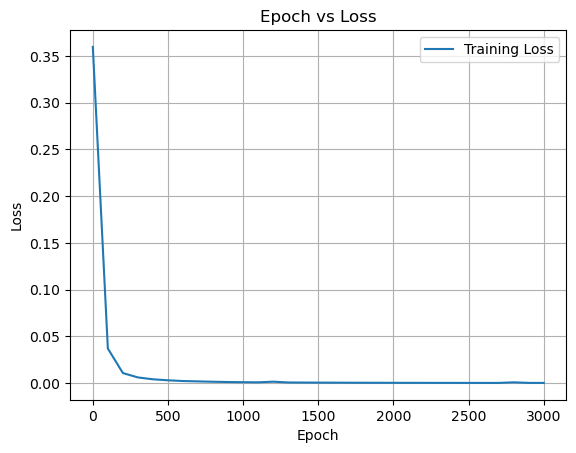

In [106]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1) 
        )

    def forward(self, x, y):
        T = self.net(torch.cat([x,y], dim=1))
        return T
    
model = PINN()

def pde(x,y):
    x.requires_grad=True
    y.requires_grad=True
    T = model(x,y)
    T_x = torch.autograd.grad(T, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_y = torch.autograd.grad(T, y, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_xx = torch.autograd.grad(T_x, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_yy = torch.autograd.grad(T_y, y, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    residual = torch.mean((T_xx + T_yy)**2)
    return residual

#Domain Size
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 1.0

# Residual Points
x_r, y_r = torch.rand(5000)*(xmax-xmin) + xmin, torch.rand(5000)*(ymax-ymin) + ymin
x_r = x_r.view(-1,1)
y_r = y_r.view(-1,1)

# Boundary points
y_left_right = torch.linspace(ymin, ymax, 200).view(-1,1)

x_left_bc = xmin*torch.ones_like(y_left_right).view(-1,1)
x_right_bc = xmax*torch.ones_like(y_left_right).view(-1,1)

x_top_bottom = torch.linspace(xmin+0.01, xmax-0.01, 200).view(-1,1)

y_top_bc = ymax*torch.ones_like(x_top_bottom).view(-1,1)
y_bottom_bc = ymin*torch.ones_like(x_top_bottom).view(-1,1)

T_left = torch.zeros_like(x_left_bc).view(-1,1)
T_right = torch.zeros_like(x_right_bc).view(-1,1)

T_bottom = torch.zeros_like(y_bottom_bc).view(-1,1)
T_top = torch.ones_like(y_bottom_bc).view(-1,1)

y_bc = torch.cat([y_left_right,y_left_right, y_top_bc, y_bottom_bc], dim=0)
x_bc = torch.cat([x_left_bc,x_right_bc, x_top_bottom, x_top_bottom], dim=0)
T_bc = torch.cat([T_left, T_right, T_top, T_bottom], dim=0)

def bc_condition(x,y,T):
    T_pred = model(x,y)
    return torch.mean((T - T_pred)**2) # return boundary loss

# Loss function combining PDE, initial condition and boundary condition
def loss_func(x_bc, y_bc, T_bc, x_r, y_r):

    boundary_loss = bc_condition(x_bc,y_bc,T_bc)
    
    pde_loss = pde(x_r, y_r)

    return pde_loss + boundary_loss

# Training setup
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 3001

# Lists to store epoch and loss values
epoch_list = []
loss_list = []

# Training loop
for epoch in range(num_epochs):
    loss = loss_func(x_bc, y_bc, T_bc, x_r, y_r)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.8f}")
        # Appending epoch and loss 
        epoch_list.append(epoch)
        loss_list.append(loss.item())

# epoch vs loss graph
plt.plot(epoch_list, loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.grid(True)
plt.show()



Activation Function: Sigmoid

Epoch 0, Loss: 0.69513977
Epoch 100, Loss: 0.18534172
Epoch 200, Loss: 0.17733130
Epoch 300, Loss: 0.14054835
Epoch 400, Loss: 0.11727187
Epoch 500, Loss: 0.10138690
Epoch 600, Loss: 0.09286079
Epoch 700, Loss: 0.09147216
Epoch 800, Loss: 0.08920772
Epoch 900, Loss: 0.08544761
Epoch 1000, Loss: 0.08041856
Epoch 1100, Loss: 0.07631660
Epoch 1200, Loss: 0.07217437
Epoch 1300, Loss: 0.06549127
Epoch 1400, Loss: 0.05360170
Epoch 1500, Loss: 0.04027120
Epoch 1600, Loss: 0.03215766
Epoch 1700, Loss: 0.02871934
Epoch 1800, Loss: 0.02715388
Epoch 1900, Loss: 0.02617056
Epoch 2000, Loss: 0.02548440
Epoch 2100, Loss: 0.02499881
Epoch 2200, Loss: 0.02474300
Epoch 2300, Loss: 0.02426785
Epoch 2400, Loss: 0.02404653
Epoch 2500, Loss: 0.02377918
Epoch 2600, Loss: 0.02359379
Epoch 2700, Loss: 0.02338580
Epoch 2800, Loss: 0.02321560
Epoch 2900, Loss: 0.02303438
Epoch 3000, Loss: 0.02298178


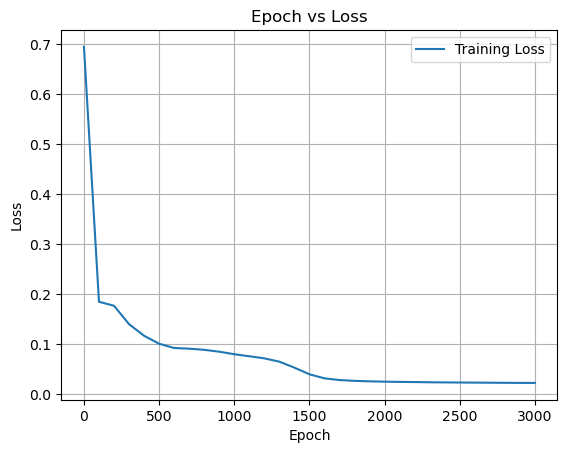

In [108]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Sigmoid(),
            nn.Linear(50, 50),
            nn.Sigmoid(),
            nn.Linear(50, 50),
            nn.Sigmoid(),
            nn.Linear(50, 1) 
        )

    def forward(self, x, y):
        T = self.net(torch.cat([x,y], dim=1))
        return T
    
model = PINN()

def pde(x,y):
    x.requires_grad=True
    y.requires_grad=True
    T = model(x,y)
    T_x = torch.autograd.grad(T, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_y = torch.autograd.grad(T, y, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_xx = torch.autograd.grad(T_x, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_yy = torch.autograd.grad(T_y, y, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    residual = torch.mean((T_xx + T_yy)**2)
    return residual

#Domain Size
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 1.0

# Residual Points
x_r, y_r = torch.rand(5000)*(xmax-xmin) + xmin, torch.rand(5000)*(ymax-ymin) + ymin
x_r = x_r.view(-1,1)
y_r = y_r.view(-1,1)

# Boundary points
y_left_right = torch.linspace(ymin, ymax, 200).view(-1,1)

x_left_bc = xmin*torch.ones_like(y_left_right).view(-1,1)
x_right_bc = xmax*torch.ones_like(y_left_right).view(-1,1)

x_top_bottom = torch.linspace(xmin+0.01, xmax-0.01, 200).view(-1,1)

y_top_bc = ymax*torch.ones_like(x_top_bottom).view(-1,1)
y_bottom_bc = ymin*torch.ones_like(x_top_bottom).view(-1,1)

T_left = torch.zeros_like(x_left_bc).view(-1,1)
T_right = torch.zeros_like(x_right_bc).view(-1,1)

T_bottom = torch.zeros_like(y_bottom_bc).view(-1,1)
T_top = torch.ones_like(y_bottom_bc).view(-1,1)

y_bc = torch.cat([y_left_right,y_left_right, y_top_bc, y_bottom_bc], dim=0)
x_bc = torch.cat([x_left_bc,x_right_bc, x_top_bottom, x_top_bottom], dim=0)
T_bc = torch.cat([T_left, T_right, T_top, T_bottom], dim=0)

def bc_condition(x,y,T):
    T_pred = model(x,y)
    return torch.mean((T - T_pred)**2) # return boundary loss

# Loss function combining PDE, initial condition and boundary condition
def loss_func(x_bc, y_bc, T_bc, x_r, y_r):

    boundary_loss = bc_condition(x_bc,y_bc,T_bc)
    
    pde_loss = pde(x_r, y_r)

    return pde_loss + boundary_loss

# Training setup
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 3001

# Lists to store epoch and loss values
epoch_list = []
loss_list = []

# Training loop
for epoch in range(num_epochs):
    loss = loss_func(x_bc, y_bc, T_bc, x_r, y_r)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.8f}")
        # Appending epoch and loss 
        epoch_list.append(epoch)
        loss_list.append(loss.item())

# epoch vs loss graph
plt.plot(epoch_list, loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.grid(True)
plt.show()



Activation function: LeakyReLU

Epoch 0, Loss: 0.21266980
Epoch 100, Loss: 0.02037209
Epoch 200, Loss: 0.00832310
Epoch 300, Loss: 0.00524643
Epoch 400, Loss: 0.00387830
Epoch 500, Loss: 0.00313250
Epoch 600, Loss: 0.00269048
Epoch 700, Loss: 0.00263587
Epoch 800, Loss: 0.00200593
Epoch 900, Loss: 0.00171989
Epoch 1000, Loss: 0.00167496
Epoch 1100, Loss: 0.00137420
Epoch 1200, Loss: 0.00150672
Epoch 1300, Loss: 0.00116130
Epoch 1400, Loss: 0.00124010
Epoch 1500, Loss: 0.00205806
Epoch 1600, Loss: 0.00090773
Epoch 1700, Loss: 0.00081334
Epoch 1800, Loss: 0.00081043
Epoch 1900, Loss: 0.00068019
Epoch 2000, Loss: 0.00062783
Epoch 2100, Loss: 0.00059107
Epoch 2200, Loss: 0.00056238
Epoch 2300, Loss: 0.00520909
Epoch 2400, Loss: 0.00045779
Epoch 2500, Loss: 0.00047977
Epoch 2600, Loss: 0.00159127
Epoch 2700, Loss: 0.00044698
Epoch 2800, Loss: 0.00034917
Epoch 2900, Loss: 0.00035948
Epoch 3000, Loss: 0.00031049


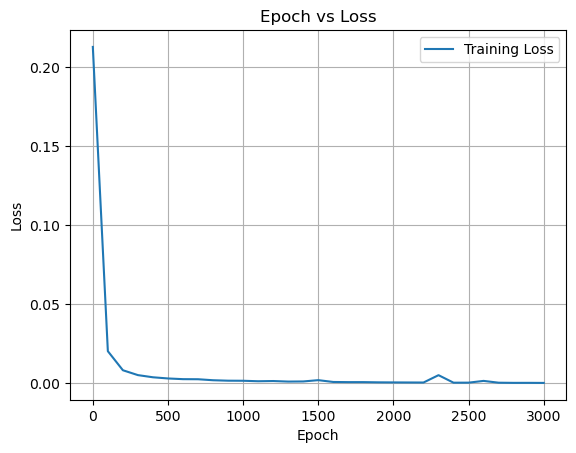

In [109]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.LeakyReLU(),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
            nn.Linear(50, 1) 
        )

    def forward(self, x, y):
        T = self.net(torch.cat([x,y], dim=1))
        return T
    
model = PINN()

def pde(x,y):
    x.requires_grad=True
    y.requires_grad=True
    T = model(x,y)
    T_x = torch.autograd.grad(T, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_y = torch.autograd.grad(T, y, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_xx = torch.autograd.grad(T_x, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_yy = torch.autograd.grad(T_y, y, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    residual = torch.mean((T_xx + T_yy)**2)
    return residual

#Domain Size
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 1.0

# Residual Points
x_r, y_r = torch.rand(5000)*(xmax-xmin) + xmin, torch.rand(5000)*(ymax-ymin) + ymin
x_r = x_r.view(-1,1)
y_r = y_r.view(-1,1)

# Boundary points
y_left_right = torch.linspace(ymin, ymax, 200).view(-1,1)

x_left_bc = xmin*torch.ones_like(y_left_right).view(-1,1)
x_right_bc = xmax*torch.ones_like(y_left_right).view(-1,1)

x_top_bottom = torch.linspace(xmin+0.01, xmax-0.01, 200).view(-1,1)

y_top_bc = ymax*torch.ones_like(x_top_bottom).view(-1,1)
y_bottom_bc = ymin*torch.ones_like(x_top_bottom).view(-1,1)

T_left = torch.zeros_like(x_left_bc).view(-1,1)
T_right = torch.zeros_like(x_right_bc).view(-1,1)

T_bottom = torch.zeros_like(y_bottom_bc).view(-1,1)
T_top = torch.ones_like(y_bottom_bc).view(-1,1)

y_bc = torch.cat([y_left_right,y_left_right, y_top_bc, y_bottom_bc], dim=0)
x_bc = torch.cat([x_left_bc,x_right_bc, x_top_bottom, x_top_bottom], dim=0)
T_bc = torch.cat([T_left, T_right, T_top, T_bottom], dim=0)

def bc_condition(x,y,T):
    T_pred = model(x,y)
    return torch.mean((T - T_pred)**2) # return boundary loss

# Loss function combining PDE, initial condition and boundary condition
def loss_func(x_bc, y_bc, T_bc, x_r, y_r):

    boundary_loss = bc_condition(x_bc,y_bc,T_bc)
    
    pde_loss = pde(x_r, y_r)

    return pde_loss + boundary_loss

# Training setup
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 3001

# Lists to store epoch and loss values
epoch_list = []
loss_list = []

# Training loop
for epoch in range(num_epochs):
    loss = loss_func(x_bc, y_bc, T_bc, x_r, y_r)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.8f}")
        # Appending epoch and loss 
        epoch_list.append(epoch)
        loss_list.append(loss.item())

# epoch vs loss graph
plt.plot(epoch_list, loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.grid(True)
plt.show()



Activation function: ELU (Exponential Linear Unit)

Epoch 0, Loss: 0.22889836
Epoch 100, Loss: 0.08954495
Epoch 200, Loss: 0.07172304
Epoch 300, Loss: 0.06227388
Epoch 400, Loss: 0.05783530
Epoch 500, Loss: 0.06661286
Epoch 600, Loss: 0.06302757
Epoch 700, Loss: 0.06450273
Epoch 800, Loss: 0.06635758
Epoch 900, Loss: 0.06284533
Epoch 1000, Loss: 0.06047511
Epoch 1100, Loss: 0.05965824
Epoch 1200, Loss: 0.05900823
Epoch 1300, Loss: 0.05828624
Epoch 1400, Loss: 0.06499942
Epoch 1500, Loss: 0.05844467
Epoch 1600, Loss: 0.06385386
Epoch 1700, Loss: 0.06504989
Epoch 1800, Loss: 0.06231520
Epoch 1900, Loss: 0.05662656
Epoch 2000, Loss: 0.05825126
Epoch 2100, Loss: 0.05657477
Epoch 2200, Loss: 0.05496383
Epoch 2300, Loss: 0.06675205
Epoch 2400, Loss: 0.05646451
Epoch 2500, Loss: 0.05443435
Epoch 2600, Loss: 0.05364917
Epoch 2700, Loss: 0.05661172
Epoch 2800, Loss: 0.05276997
Epoch 2900, Loss: 0.05197205
Epoch 3000, Loss: 0.04881051


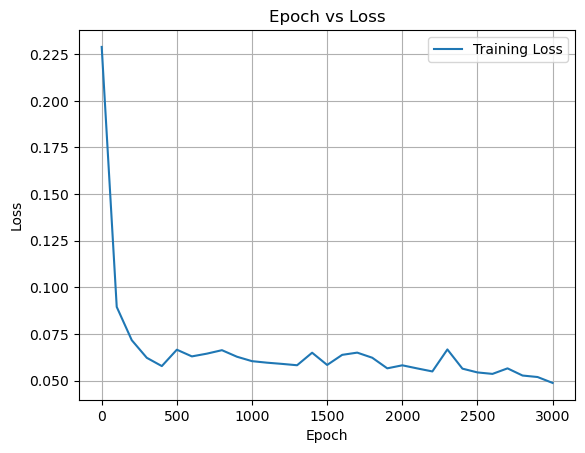

In [110]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.ELU(),
            nn.Linear(50, 50),
            nn.ELU(),
            nn.Linear(50, 50),
            nn.ELU(),
            nn.Linear(50, 1) 
        )

    def forward(self, x, y):
        T = self.net(torch.cat([x,y], dim=1))
        return T
    
model = PINN()

def pde(x,y):
    x.requires_grad=True
    y.requires_grad=True
    T = model(x,y)
    T_x = torch.autograd.grad(T, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_y = torch.autograd.grad(T, y, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_xx = torch.autograd.grad(T_x, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_yy = torch.autograd.grad(T_y, y, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    residual = torch.mean((T_xx + T_yy)**2)
    return residual

#Domain Size
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 1.0

# Residual Points
x_r, y_r = torch.rand(5000)*(xmax-xmin) + xmin, torch.rand(5000)*(ymax-ymin) + ymin
x_r = x_r.view(-1,1)
y_r = y_r.view(-1,1)

# Boundary points
y_left_right = torch.linspace(ymin, ymax, 200).view(-1,1)

x_left_bc = xmin*torch.ones_like(y_left_right).view(-1,1)
x_right_bc = xmax*torch.ones_like(y_left_right).view(-1,1)

x_top_bottom = torch.linspace(xmin+0.01, xmax-0.01, 200).view(-1,1)

y_top_bc = ymax*torch.ones_like(x_top_bottom).view(-1,1)
y_bottom_bc = ymin*torch.ones_like(x_top_bottom).view(-1,1)

T_left = torch.zeros_like(x_left_bc).view(-1,1)
T_right = torch.zeros_like(x_right_bc).view(-1,1)

T_bottom = torch.zeros_like(y_bottom_bc).view(-1,1)
T_top = torch.ones_like(y_bottom_bc).view(-1,1)

y_bc = torch.cat([y_left_right,y_left_right, y_top_bc, y_bottom_bc], dim=0)
x_bc = torch.cat([x_left_bc,x_right_bc, x_top_bottom, x_top_bottom], dim=0)
T_bc = torch.cat([T_left, T_right, T_top, T_bottom], dim=0)

def bc_condition(x,y,T):
    T_pred = model(x,y)
    return torch.mean((T - T_pred)**2) # return boundary loss

# Loss function combining PDE, initial condition and boundary condition
def loss_func(x_bc, y_bc, T_bc, x_r, y_r):

    boundary_loss = bc_condition(x_bc,y_bc,T_bc)
    
    pde_loss = pde(x_r, y_r)

    return pde_loss + boundary_loss

# Training setup
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 3001

# Lists to store epoch and loss values
epoch_list = []
loss_list = []

# Training loop
for epoch in range(num_epochs):
    loss = loss_func(x_bc, y_bc, T_bc, x_r, y_r)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.8f}")
        # Appending epoch and loss 
        epoch_list.append(epoch)
        loss_list.append(loss.item())

# epoch vs loss graph
plt.plot(epoch_list, loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.grid(True)
plt.show()

